<a href="https://colab.research.google.com/github/akibkhan1/IMGS-689-ML-In-Remote-Sensing-HW-Solutions/blob/main/Khan_Akib_IMGS_689_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1
### Author: Akib Mohammed Khan

Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

Load Sentinel Data

In [5]:
!unzip sentinel2_rochester.npy.zip

Archive:  sentinel2_rochester.npy.zip
  inflating: sentinel2_rochester.npy  
  inflating: __MACOSX/._sentinel2_rochester.npy  


In [19]:
data = np.load('sentinel2_rochester.npy')
oak_data_path = "/JPL_Data/oak.txt"
asphalt_data_path = "/JPL_Data/asphalt.txt"

## Problem 1: Plotting

Identifying corresponding central wavelength (λ) for each band. Using resource from [sentinelhub](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/bands)


*   Band 1: **443nm**
*   Band 2: **490nm**
*   Band 3: **560nm**
*   Band 4: **665nm**
*   Band 5: **705nm**
*   Band 6: **740nm**
*   Band 7: **783nm**
*   Band 8: **842nm**
*   Band 8A: **865nm**
*   Band 9: **945nm**
*   Band 11: **1610nm**
*   Band 12: **2190nm**

For all plots, I used the 'nipy_spectral' colormap for vibrant visualizations.


For better visualization I used contrast stretching where the image is rescaled to include all surface reflectance values that fall within the 2nd and 98th percentiles instead of absolute min/max values [[1](
http://homepages.inf.ed.ac.uk/rbf/HIPR2/stretch.htm)]. This improved the visual contrast of the images and made the plots more detailed.

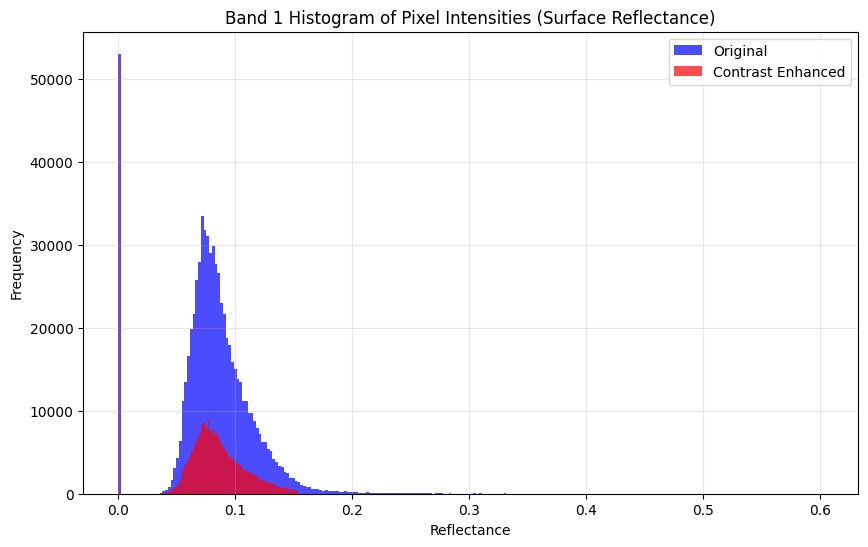

In [17]:
pixel_values = data[:, :, 0].flatten()
p2, p98 = np.nanpercentile(data[:, :, 0], (2, 98))
clipped_data = np.clip(data[:, :, 0], p2, p98)
clipped_pixel_values = clipped_data.flatten()
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(pixel_values, bins=256, alpha=0.7, color='blue', label='Original')
plt.hist(clipped_pixel_values, bins=256, alpha=0.7, color='red', label='Contrast Enhanced')
plt.xlabel('Reflectance')
plt.ylabel('Frequency')
plt.title('Band 1 Histogram of Pixel Intensities (Surface Reflectance)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

From observing surface reflectence values for each band it seems that the no_data regions are 0 values. In order to ignore these 0's when plotting I converted the 0's to NaNs and ignored the NaN values.

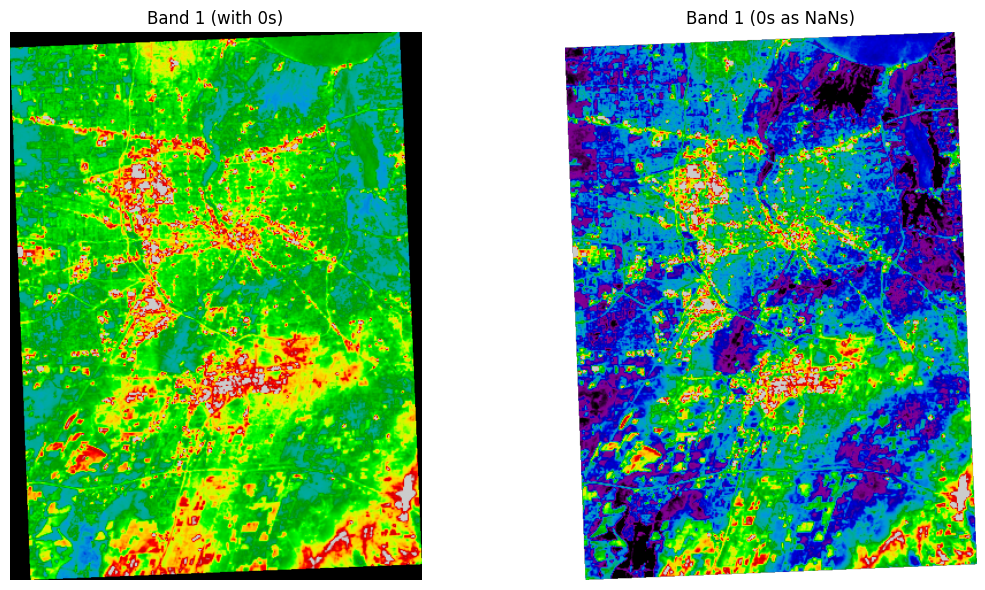

In [18]:
plt.figure(figsize=(12, 6))
# Plot with zeros included
plt.subplot(1, 2, 1)
p2_zeros, p98_zeros = np.percentile(data[:, :, 0], (2, 98))
clipped_data_zeros = np.clip(data[:, :, 0], p2_zeros, p98_zeros)
plt.imshow(clipped_data_zeros, cmap='nipy_spectral')
plt.title('Band 1 (with 0s)')
plt.axis('off')

# Plot with zeros converted to NaNs and ignored
plt.subplot(1, 2, 2)
data_nan = data.copy()
data_nan[data_nan == 0] = np.nan
p2_nan, p98_nan = np.nanpercentile(data_nan[:, :, 0], (2, 98))
clipped_data_nan = np.clip(data_nan[:, :, 0], p2_nan, p98_nan)
plt.imshow(clipped_data_nan, cmap='nipy_spectral')
plt.title('Band 1 (0s as NaNs)')
plt.axis('off')

plt.tight_layout()
plt.show()

Putting it all together and plotting each band

<>:21: SyntaxWarning: invalid escape sequence '\l'
<>:21: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-548712501.py:21: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f'Band {band_names[i]}, $\lambda$={wavelength[i]}')


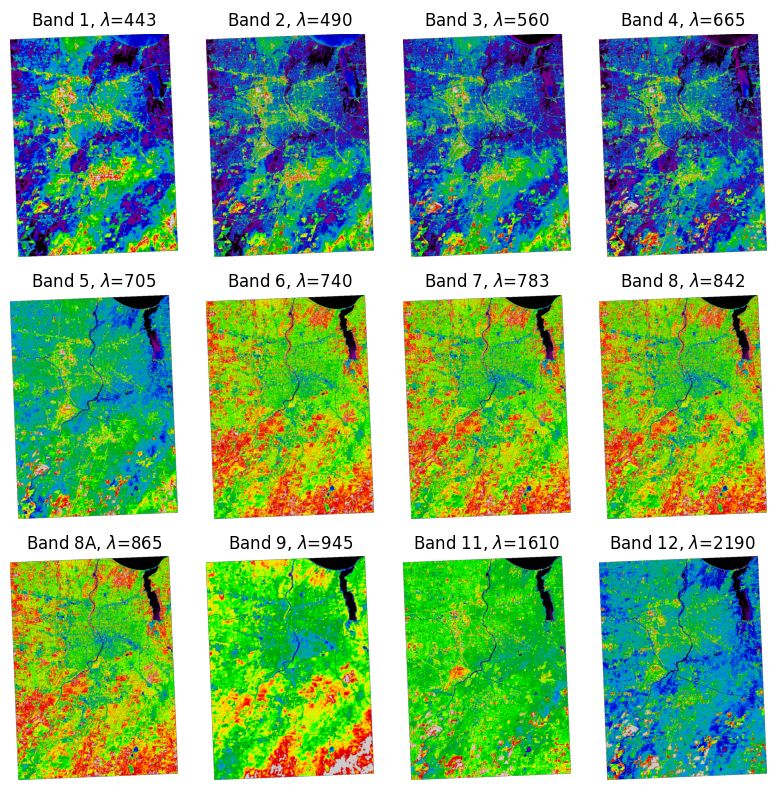

In [19]:
def plot_maps(data):
  fig, axs = plt.subplots(nrows=3, ncols = 4, figsize=(8, 8))
  wavelength = [443, 490, 560, 665, 705, 740, 783, 842, 865, 945, 1610, 2190]
  band_names = [1, 2, 3, 4, 5, 6, 7, 8, '8A', 9, 11, 12]

  # Convert 0's to NaN values
  data_nan = data.copy()
  data_nan[data==0]= np.nan
  for i in range(data.shape[-1]):
      row = i // 4
      col = i % 4
      ax = axs[row, col]

      # Calculate 2nd and 95th percentiles, ignoring NaNs
      p2, p98 = np.nanpercentile(data_nan[:, :, i], (2, 98))

      # Clip the data to the percentile range
      clipped_data = np.clip(data_nan[:, :, i], p2, p98)

      ax.imshow(clipped_data, cmap='nipy_spectral')
      ax.set_title(f'Band {band_names[i]}, $\lambda$={wavelength[i]}')
      ax.axis('off')

  plt.tight_layout()
  plt.show()

plot_maps(data)

## Problem 2

(a) Statistics

*   **Mean**: The average value of the pixel intensities in the band. It gives the average surface reflectance from each band.
*   **Standard Deviation**: Measures the dispersion or spread of the pixel intensities around the mean. A higher standard deviation indicates a wider range of reflectance values and more variation within the band.
*   **Minimum**: The lowest reflectance value found in the band.
*   **Maximum**: The highest reflectance value found in the band.
*   **Quartiles (Q1, Median, Q3)**: These divide the data into four equal parts.
    *   **Q1**: 25% of the reflectance values are below this value.
    *   **Median**: The middle value when the reflectance values are sorted. 50% of the values are below this.
    *   **Q3**: 75% of the reflectance values are below this value.
*   **Skewness**: Measures the asymmetry of the distribution of surface reflectance.
    *   A skewness of 0 indicates a perfectly symmetrical distribution.
    *   Positive skewness means the tail of the distribution is longer on the right side (more high values).
    *   Negative skewness means the tail is longer on the left side (more low values).
*   **Kurtosis**: Measures the "tailedness" of the distribution. It tells us how much of the data is in the tails compared to the normal distribution.
    *   Higher kurtosis means more of the variance is due to infrequent extreme values (heavier tails).
    *   Lower kurtosis means more of the variance is due to moderately extreme values (lighter tails).

In [20]:
import pandas as pd
from scipy.stats import skew, kurtosis

def calculate_band_statistics(data):
    band_names = [1, 2, 3, 4, 5, 6, 7, 8, '8A', 9, 11, 12]
    statistics = {}

    # Convert 0s to NaNs for accurate statistics
    data_nan = data.copy()
    data_nan[data_nan == 0] = np.nan

    for i in range(data_nan.shape[-1]):
        band_data = data_nan[:, :, i].flatten()
        band_data = band_data[~np.isnan(band_data)] # Remove NaNs for skewness and kurtosis

        if band_data.size > 0:
            statistics[band_names[i]] = {
                'Mean': np.nanmean(data_nan[:, :, i]),
                'Standard Deviation': np.nanstd(data_nan[:, :, i]),
                'Minimum': np.nanmin(data_nan[:, :, i]),
                'Maximum': np.nanmax(data_nan[:, :, i]),
                'Q1': np.nanpercentile(data_nan[:, :, i], 25),
                'Median': np.nanpercentile(data_nan[:, :, i], 50),
                'Q3': np.nanpercentile(data_nan[:, :, i], 75),
                'Skewness': skew(band_data),
                'Kurtosis': kurtosis(band_data)
            }
        else:
             statistics[band_names[i]] = {
                'Mean': np.nan,
                'Standard Deviation': np.nan,
                'Minimum': np.nan,
                'Maximum': np.nan,
                'Q1': np.nan,
                'Median': np.nan,
                'Q3': np.nan,
                'Skewness': np.nan,
                'Kurtosis': np.nan
            }


    return pd.DataFrame.from_dict(statistics, orient='index')

# Calculate and display statistics
stats = calculate_band_statistics(data)
display(stats)

,Mean,Standard Deviation,Minimum,Maximum,Q1,Median,Q3,Skewness,Kurtosis
1,0.088682,0.027914,0.0333,0.6021,0.0709,0.0829,0.1007,2.920508,23.797392
2,0.092542,0.035001,0.0386,0.7542,0.0716,0.0853,0.1053,4.478896,43.108045
3,0.105496,0.034365,0.0430,0.7484,0.0858,0.0987,0.1168,4.692240,46.293076
4,0.094311,0.044454,0.0326,0.7728,0.0663,0.0850,0.1093,3.231439,23.407628
5,0.136721,0.040905,0.0346,0.8159,0.1152,0.1310,0.1506,3.108017,27.351370
6,0.243593,0.061036,0.0176,0.7830,0.2131,0.2472,0.2830,-0.708535,3.406103
7,0.285838,0.077305,0.0161,0.7859,0.2444,0.2903,0.3377,-0.710117,1.720142
8,0.291384,0.080328,0.0188,0.9030,0.2475,0.2976,0.3464,-0.716092,1.422177
8A,0.303507,0.082224,0.0157,0.7689,0.2605,0.3098,0.3595,-0.821525,1.674276
9,0.345083,0.077947,0.0653,0.6934,0.3052,0.3446,0.3882,-0.395654,2.210019


(b) Standardization

Applying Standardization transforms the band data such that it has a mean of 0 and a standard deviation of 1. It centers the data by subtracting the mean of the band from each pixel value. It also scales the data by dividing the centered data by the standard deviation of the band.

In [57]:
def standardize_data(data):
    standardized_data = np.full_like(data, np.nan, dtype=float) # Initialize with NaNs

    for i in range(data.shape[-1]):
        band_data = data[:, :, i].flatten()
        band_data = band_data[~np.isnan(band_data)] # Remove NaNs for mean and std calculation

        if band_data.size > 0:
            mean = np.nanmean(data[:, :, i])
            std = np.nanstd(data[:, :, i])

            # Avoid division by zero if std is zero
            if std != 0:
                standardized_data[:, :, i] = (data[:, :, i] - mean) / std
            else:
                standardized_data[:, :, i] = np.nan # Set to NaN if std is zero


    return standardized_data

# Standardize the data
standardized_data = standardize_data(data)

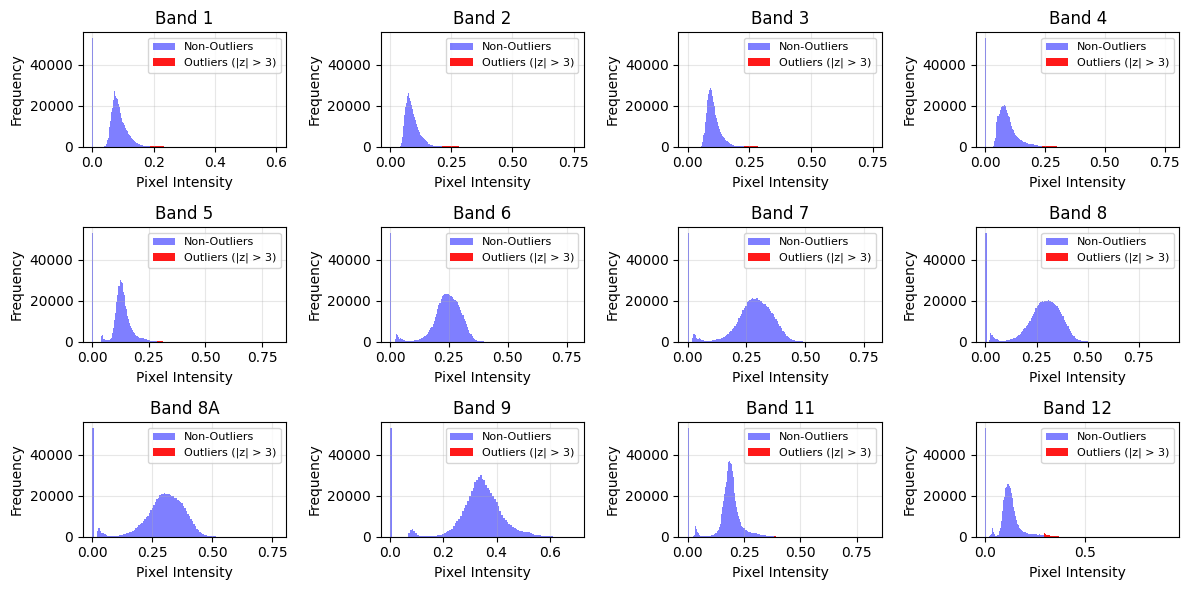

In [59]:
def plot_histograms_with_outliers(data, standardized_data):
    band_names = [1, 2, 3, 4, 5, 6, 7, 8, '8A', 9, 11, 12]
    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12, 6)) # Adjust figure size

    for i in range(data.shape[-1]):
        row = i // 4
        col = i % 4
        ax = axs[row, col]

        original_band_data = data[:, :, i].flatten()
        standardized_band_data = standardized_data[:, :, i].flatten()

        # Remove NaNs for plotting
        original_band_data_cleaned = original_band_data[~np.isnan(original_band_data)]
        standardized_band_data_cleaned = standardized_band_data[~np.isnan(standardized_band_data)]

        # Define outlier threshold (e.g., |z-score| > 3)
        outlier_threshold = 3

        # Identify outliers in the original data based on standardized data
        outliers = original_band_data_cleaned[np.abs(standardized_band_data_cleaned) > outlier_threshold]
        non_outliers = original_band_data_cleaned[np.abs(standardized_band_data_cleaned) <= outlier_threshold]

        # Plot histogram of non-outliers
        ax.hist(non_outliers, bins=100, color='blue', alpha=0.5, label='Non-Outliers')

        # Plot histogram of outliers
        ax.hist(outliers, bins=100, color='red', alpha=0.9, label=f'Outliers (|z| > {outlier_threshold})')

        ax.set_xlabel('Pixel Intensity')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Band {band_names[i]}')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot histograms with outliers in a grid
plot_histograms_with_outliers(data, standardized_data)

## Problem 3

(a) Correlation Matrix (Pair Plots)

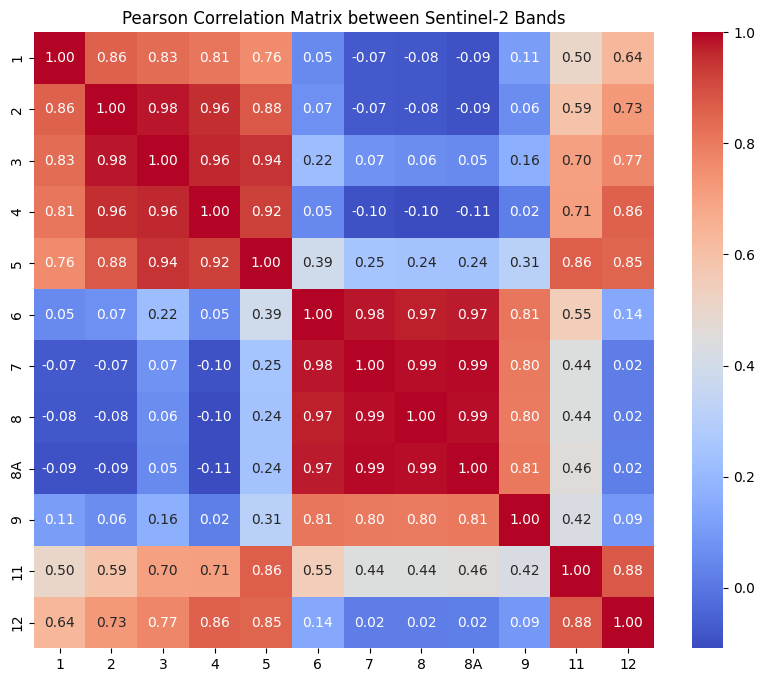

In [24]:
def correlation_matrix(data):
    band_names = [1, 2, 3, 4, 5, 6, 7, 8, '8A', 9, 11, 12]
    num_bands = data.shape[-1]
    correlation_matrix = np.zeros((num_bands, num_bands))

    # Convert 0s to NaNs for accurate correlation calculation
    data_nan = data.copy()
    data_nan[data_nan == 0] = np.nan

    for i in range(num_bands):
        for j in range(num_bands):
            # Flatten the bands and remove NaNs for correlation calculation
            band_i = data_nan[:, :, i].flatten()
            band_j = data_nan[:, :, j].flatten()

            # Remove pairs where either value is NaN
            valid_indices = ~np.isnan(band_i) & ~np.isnan(band_j)
            band_i_cleaned = band_i[valid_indices]
            band_j_cleaned = band_j[valid_indices]

            if band_i_cleaned.size > 1 and band_j_cleaned.size > 1: # Need at least 2 data points to calculate correlation
                correlation_matrix[i, j] = np.corrcoef(band_i_cleaned, band_j_cleaned)[0, 1]
            else:
                correlation_matrix[i, j] = np.nan # Set to NaN if not enough valid data points


    return pd.DataFrame(correlation_matrix, index=band_names, columns=band_names)

# Calculate the correlation matrix
corr_matrix = correlation_matrix(data)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Pearson Correlation Matrix between Sentinel-2 Bands')
plt.show()

I plotted the matrix as a heatmap image. This matrix where each cell represents the correlation between two bands is a symmetric square matrix called a pair-plot.

Bands that are highly positively correlated show similar patterns of reflectance. For example, bands 2, 3, and 4 have high positive correlations with each other (all above 0.95). These bands are in the visible light spectrum (blue, green, and red) and often exhibit similar reflectance behavior for many surface types.

Bands 6, 7, 8, and 8A also show very high positive correlations (all above 0.97). These are in the near-infrared (NIR) and short-wave infrared (SWIR) portions of the spectrum, which are highly sensitive to vegetation and water content.

Low correlation values suggest a weak linear relationship between the bands. For instance, the correlations between the visible bands (1-4) and the NIR/SWIR bands (6-8A) are generally low, some even negative (e.g., Band 4 with Bands 7, 8, and 8A). This is because different surface types have distinct reflectance characteristics in different parts of the electromagnetic spectrum. For example, vegetation has low reflectance in visible light and high reflectance in NIR.

(b) Scatter and Density Plot

I initially tried to used seaborn KDE density plot but it was taking too long, so I went for 2-D histogram with shading which conveys the same information.

The scatter plots and density maps between bands B2 (Blue), B3 (Green), and B4 (Red) show strong positive linear relationships. The points tend to cluster along a diagonal line, indicating that as the reflectance increases in one visible band, it also tends to increase in the others. The density plots highlight that the majority of pixels have relatively low reflectance values in these bands, with some clusters representing features with higher reflectance.

Bands B3 and B4 show a moderate positive correlation with Band 8 (NIR). While there's a general trend of increasing NIR reflectance with increasing green and red reflectance, the relationship is not as tight as within the visible bands. This is because vegetation has relatively low reflectance in the visible bands but high reflectance in the NIR. The scatter plots show a wider spread of points, and the density plots reveal elongated clusters.

Band 2 (Blue) generally shows a weaker positive correlation with Band 8 (NIR) compared to B3 and B4. Water absorbs blue light, while vegetation reflects strongly in the NIR. This difference in spectral response for water bodies can contribute to a less pronounced linear relationship between the blue and NIR bands.

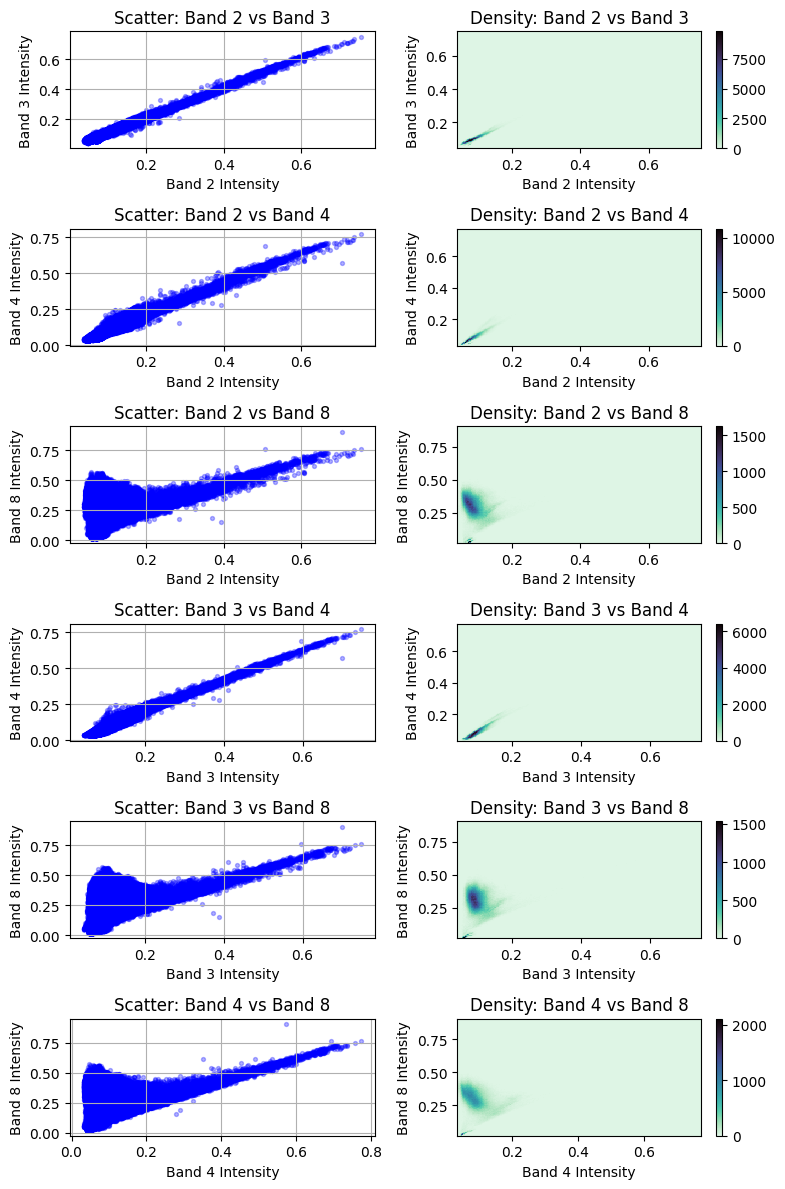

In [55]:
def correlation_plot(data):

    bands = [2, 3, 4, 8]
    band_pairs = list(itertools.combinations(bands, 2))

    # Convert 0s to NaNs to ignore no-data values and flatten the data
    data_nan = data.copy().reshape(-1, data.shape[-1])
    data_nan[data_nan == 0] = np.nan
    # Get indices of valid (non-NaN) data points
    valid_indices_mask = ~np.isnan(data_nan).any(axis=1)
    valid_data = data_nan[valid_indices_mask]

    n = len(band_pairs)
    fig, axes = plt.subplots(n, 2, figsize=(8, 2*n))

    for i, (band_x, band_y) in enumerate(band_pairs):
        # Convert to 0-based index
        band_x -= 1
        band_y -= 1

        # Scatter plot
        axes[i, 0].scatter(valid_data[:, band_x], valid_data[:, band_y], alpha=0.3, s=8, color="blue")
        axes[i, 0].set_title(f"Scatter: Band {band_x+1} vs Band {band_y+1}")
        axes[i, 0].set_xlabel(f"Band {band_x+1} Intensity")
        axes[i, 0].set_ylabel(f"Band {band_y+1} Intensity")
        axes[i, 0].grid(True)

        # Density plot
        hb = axes[i, 1].hist2d(valid_data[:, band_x], valid_data[:, band_y], bins=200, cmap="mako_r")
        axes[i, 1].set_title(f"Density: Band {band_x+1} vs Band {band_y+1}")
        axes[i, 1].set_xlabel(f"Band {band_x+1} Intensity")
        axes[i, 1].set_ylabel(f"Band {band_y+1} Intensity")
        fig.colorbar(hb[3], ax=axes[i, 1])

    plt.tight_layout()
    plt.show()

correlation_plot(data)

# Problem 4

I downloaded the Quercus genus and Construction Asphalt spectral data and used only the 0.35-2.5 micron range of wavelength for Construction Asphalt.

(a) Cosine Similarity

100 pixels with lowest spectral angle: [[0.0667 0.066  0.0935 ... 0.3643 0.2289 0.1388]
 [0.0655 0.0623 0.0885 ... 0.3293 0.2082 0.1135]
 [0.0604 0.061  0.0847 ... 0.3693 0.2291 0.125 ]
 ...
 [0.062  0.0674 0.0916 ... 0.362  0.2212 0.1266]
 [0.0604 0.0646 0.0937 ... 0.3693 0.2378 0.1269]
 [0.061  0.0662 0.0905 ... 0.3618 0.2103 0.1163]]


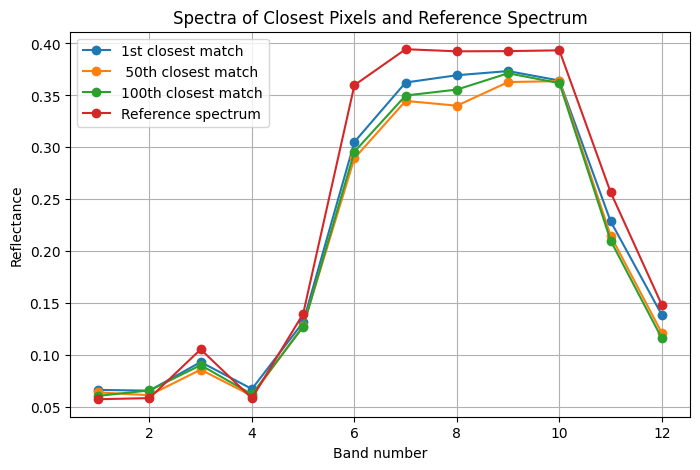

100 pixels with lowest spectral angle: [[0.252  0.2881 0.2918 ... 0.3234 0.3305 0.3053]
 [0.2421 0.2625 0.2735 ... 0.3317 0.3132 0.3022]
 [0.2281 0.2602 0.2759 ... 0.3204 0.3092 0.2887]
 ...
 [0.2349 0.2577 0.2671 ... 0.3078 0.2771 0.245 ]
 [0.1914 0.2503 0.2549 ... 0.2724 0.2732 0.2594]
 [0.2001 0.217  0.2297 ... 0.2937 0.2627 0.2461]]


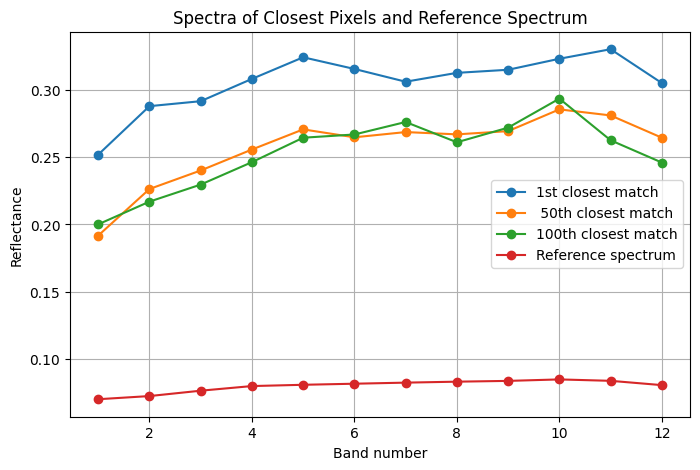

In [30]:
def sam(sentinel_data, jpl_file_path):
    jpl_data = pd.read_csv(jpl_file_path, sep=None, engine='python', header=None, names=['wavelength', 'reflectance'])

    # Scale reflectance value
    jpl_data['reflectance'] = jpl_data['reflectance'] / 100.0

    # sentinel2 wavelengths in micrometers
    target_wavelengths = np.array([0.443, 0.490, 0.560, 0.665, 0.705, 0.740,
                                  0.783, 0.842, 0.865, 0.940, 1.610, 2.190])

    interpolated_reflectance = np.interp(target_wavelengths, jpl_data['wavelength'], jpl_data['reflectance']) # downsampled to the Sentinel-2 bands

    jpl_downsized = pd.DataFrame({
        'wavelength': target_wavelengths,
        'reflectance': interpolated_reflectance
    })

    ref_spectrum = jpl_downsized['reflectance']

    pixels = sentinel_data.reshape(-1, data.shape[-1])  # (HW, 12)

    # Cosine Similarity between reference and sentinel data
    dot_product = np.dot(pixels, ref_spectrum)
    pixels_norm = np.linalg.norm(pixels, axis=1)
    ref_norm = np.linalg.norm(ref_spectrum)
    cos_theta = dot_product / ((pixels_norm * ref_norm) + 1e-12)

    angles = np.arccos(np.clip(cos_theta, -1, 1)) # radians

    # Lowest angle --> Highest similarity
    lowest_idx = np.argsort(angles)[:100]
    lowest_angles = angles[lowest_idx]
    lowest_pixels = pixels[lowest_idx]

    print(f"100 pixels with lowest spectral angle: {lowest_pixels}")

    spectra_to_plot = [lowest_pixels[0], lowest_pixels[49], lowest_pixels[99], ref_spectrum]
    labels = ["1st closest match", " 50th closest match", "100th closest match", "Reference spectrum"]

    bands = np.arange(1, 13)

    plt.figure(figsize=(8, 5))
    for spec, label in zip(spectra_to_plot, labels):
        plt.plot(bands, spec, marker='o', label=label)

    plt.xlabel("Band number")
    plt.ylabel("Reflectance")
    plt.title("Spectra of Closest Pixels and Reference Spectrum")
    plt.legend()
    plt.grid(True)
    plt.show()

sam(data, "/content/JPL_Data/oak.txt")
sam(data, "/content/JPL_Data/asphalt.txt")

**Vegetation - Quercus Genus:**

Looking at the plot for the Quercus genus, the spectral curves of the closest matched Sentinel-2 pixels show a strong resemblance to the ECOSTRESS reference spectrum. All the curves exhibit the characteristic spectral signature of healthy vegetation: low reflectance in the blue and red bands (due to chlorophyll absorption), a sharp increase in reflectance in the green band, a very high reflectance in the near-infrared (NIR) plateau, and decreasing reflectance in the short-wave infrared (SWIR) bands.

While the general shape is similar, there are some minor differences in the absolute reflectance values between the matched pixels and the reference spectrum, particularly in the NIR and SWIR regions. This could be due to variations in vegetation type within the "Quercus genus" category.

The 1st closest match pixel generally shows the closest quantitative agreement in reflectance values to the reference spectrum, as expected from the Spectral Angle Mapper algorithm. The 50th and 100th pixels show slightly larger deviations, reflecting increasing spectral angles.

**Road - Construction Asphalt:**

The spectral curves of the closest matched Sentinel-2 pixels show noticable differences, particularly in the overall reflectance levels.

The matched Sentinel-2 pixels generally have significantly higher reflectance values across all bands compared to the ECOSTRESS reference spectrum for Construction Asphalt. The reference spectrum shows very low reflectance, particularly in the visible bands, with values well below 0.1. The matched Sentinel-2 pixels, however, have reflectance values ranging from around 0.2 to over 0.3 in many bands.

The spectral shape of the matched Sentinel-2 pixels, while having some similarities, is not as flat as the ECOSTRESS reference spectrum, particularly in the NIR and SWIR regions. The matched pixels show more pronounced variations in reflectance across these bands.

The quantitative reflectance values of the matched Sentinel-2 pixels are considerably higher than the reference likely due to a combination of factors, including variations in asphalt type/condition, pixel mixing, and environmental influences. The SAM metric focuses on the shape of the spectrum (angle) rather than the absolute magnitude, which is why it still identified these pixels as the "closest" in terms of spectral shape, even if the reflectance magnitude is different.

(b) Vegetation/Road image representation

I gather all the angles for oak and asphalt.

In [36]:
def sam(sentinel_data, jpl_file_path):
    jpl_data = pd.read_csv(jpl_file_path, sep=None, engine='python', header=None, names=['wavelength', 'reflectance'])

    # Scale reflectance value
    jpl_data['reflectance'] = jpl_data['reflectance'] / 100.0

    # sentinel2 wavelengths in micrometers
    target_wavelengths = np.array([0.443, 0.490, 0.560, 0.665, 0.705, 0.740,
                                  0.783, 0.842, 0.865, 0.940, 1.610, 2.190])

    interpolated_reflectance = np.interp(target_wavelengths, jpl_data['wavelength'], jpl_data['reflectance']) # downsampled to the Sentinel-2 bands

    jpl_downsized = pd.DataFrame({
        'wavelength': target_wavelengths,
        'reflectance': interpolated_reflectance
    })

    ref_spectrum = jpl_downsized['reflectance']

    pixels = sentinel_data.reshape(-1, data.shape[-1])  # (HW, 12)

    # Cosine Similarity between reference and sentinel data
    dot_product = np.dot(pixels, ref_spectrum)
    pixels_norm = np.linalg.norm(pixels, axis=1)
    ref_norm = np.linalg.norm(ref_spectrum)
    cos_theta = dot_product / ((pixels_norm * ref_norm) + 1e-12)

    angles = np.arccos(np.clip(cos_theta, -1, 1)) # radians

    return angles

oak_angles = sam(data, oak_data_path)
asphalt_angles = sam(data, asphalt_data_path)

I analyze the distribution of spectral angles for oak and asphalt by plotting their histograms to identify potential cutoff thresholds. Based on the histograms, I select cutoff angles that capture the main cluster of low spectral angles for each class and store them in variables.



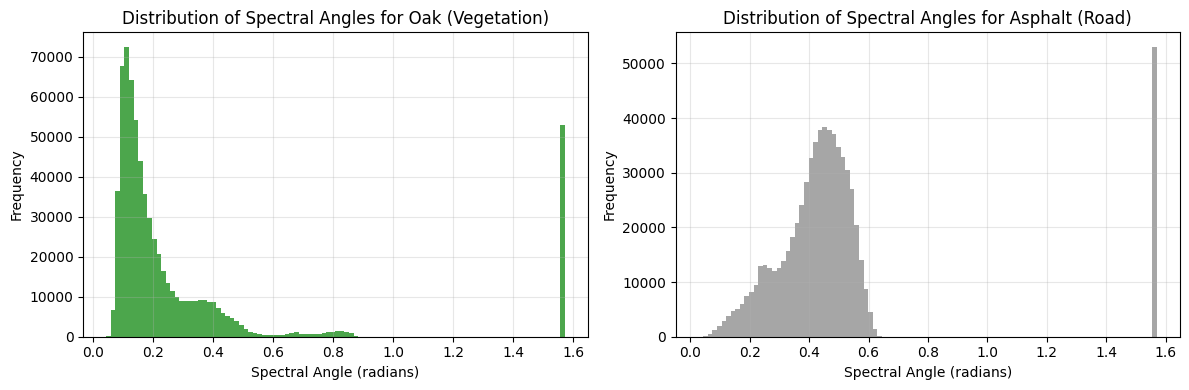

In [52]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(oak_angles, bins=100, color='green', alpha=0.7)
plt.xlabel('Spectral Angle (radians)')
plt.ylabel('Frequency')
plt.title('Distribution of Spectral Angles for Oak (Vegetation)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(asphalt_angles, bins=100, color='gray', alpha=0.7)
plt.xlabel('Spectral Angle (radians)')
plt.ylabel('Frequency')
plt.title('Distribution of Spectral Angles for Asphalt (Road)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [38]:
# Based on visual inspection of the histograms:
# For oak, the majority of low angles are below approximately 0.3 radians.
# For asphalt, the majority of low angles are below approximately 0.6 radians.
vegetation_cutoff_angle = 0.3
road_cutoff_angle = 0.6

print(f"Chosen cutoff angle for vegetation (oak): {vegetation_cutoff_angle} radians")
print(f"Chosen cutoff angle for road (asphalt): {road_cutoff_angle} radians")

Chosen cutoff angle for vegetation (oak): 0.3 radians
Chosen cutoff angle for road (asphalt): 0.6 radians


In [49]:
# 1. Reshape spectral angles back to original image dimensions
height, width = data.shape[:2]
oak_angles_reshaped = oak_angles.reshape(height, width)
asphalt_angles_reshaped = asphalt_angles.reshape(height, width)

# 2. Create boolean mask for vegetation pixels
vegetation_mask = oak_angles_reshaped <= vegetation_cutoff_angle

# 3. Create boolean mask for road pixels
road_mask = asphalt_angles_reshaped <= road_cutoff_angle

# 4. Ensure no overlap (prioritizing vegetation)
# Pixels identified as both vegetation and road will be classified as vegetation.
road_mask = road_mask & ~vegetation_mask

# Store the resulting masks
vegetation_mask_final = vegetation_mask
road_mask_final = road_mask


Finally I create an image highlighting the identified vegetation and road pixels on top of a base Sentinel-2 band for visual context. The green pixels represent vegetation while the gray pixels represent asphalt/road.



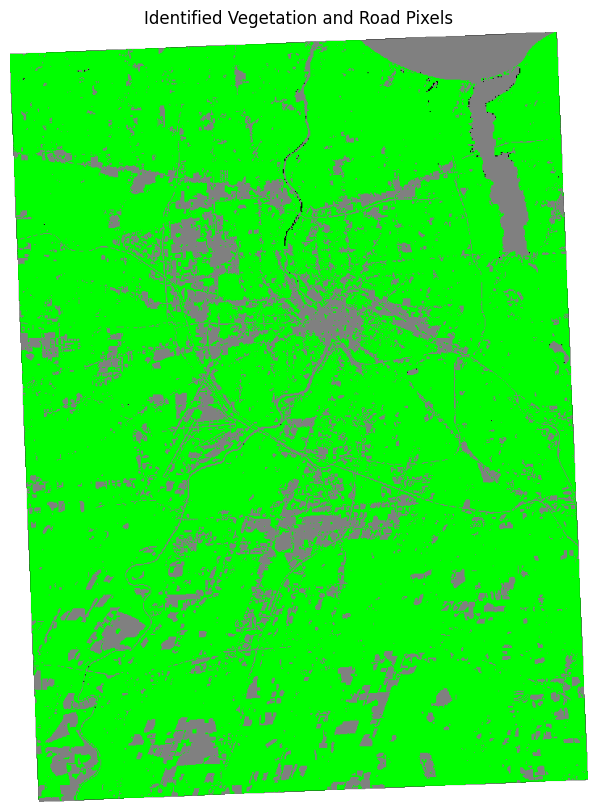

In [48]:
# Choose a base band for visualization (e.g., Band 4 - Red)
base_band_index = 3

# Get the base band data and convert 0s to NaNs for display
base_image_data = data[:, :, base_band_index].copy()
base_image_data[base_image_data == 0] = np.nan

# Apply contrast stretching to the base band for better visualization
p2, p98 = np.nanpercentile(base_image_data, (2, 98))
clipped_base_image = np.clip(base_image_data, p2, p98)

# Create an empty image to overlay the masks
highlight_image = np.zeros((*clipped_base_image.shape, 4), dtype=np.uint8)
# Define colors for vegetation and road
vegetation_color = [0, 255, 0, 255]  # Green (RGBA)
road_color = [128, 128, 128, 255]    # Gray (RGBA)

# Apply vegetation mask
highlight_image[vegetation_mask_final] = vegetation_color

# Apply road mask
highlight_image[road_mask_final] = road_color

# Create a figure and axes to display the image
plt.figure(figsize=(10, 10))

# Display the base image
plt.imshow(clipped_base_image, cmap='gray') # Use grayscale for the base image

# Overlay the highlight image
plt.imshow(highlight_image)

plt.title('Identified Vegetation and Road Pixels')
plt.axis('off')
plt.show()

# END